# Wave Net

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import re
import pandas as pd
import random

### Loading Data and Dictionaries

In [2]:
checkSpecialChar = lambda s: re.match(r"^[A-Za-z]+$", s) is not None
text_file = open('data/first_name.txt').read().splitlines()
text_file = [x.lower() for x in text_file if isinstance(x, str) and checkSpecialChar(x)]
csv_names = [x for x in pd.read_csv('data/Indian_names.csv')['Name'] if isinstance(x, str) and checkSpecialChar(x)]
words = text_file + csv_names
words = list(set(words))
len(words)

7904

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Randomizer and Parameters

In [93]:
torch.manual_seed(42)
block_size = 8
embed_size = 24
batch_size = 32
vocab_size = len(words)
chars_size = len(itos)
hidden_size = 128

### Build Dataset

In [94]:
def build_dataset(words):    
    X, Y = [], []
    for word in words:
        # print(word) 
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[ix] for ix in context]), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([46895, 8]) torch.Size([46895])
torch.Size([5861, 8]) torch.Size([5861])
torch.Size([5955, 8]) torch.Size([5955])


In [97]:
for x, y in zip(Xtr[:12], Ytr[:12]):
    print(''.join([itos[ix.item()] for ix in x]), '---->', itos[y.item()])

........ ----> k
.......k ----> a
......ka ----> i
.....kai ----> f
....kaif ----> .
........ ----> c
.......c ----> h
......ch ----> i
.....chi ----> d
....chid ----> d
...chidd ----> u
..chiddu ----> .


### Custom Layers

In [98]:
# Model Blocks
#----------------------------------------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias = True, gain = None):
       self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
       if gain:
           with torch.no_grad():
               self.weight *= gain
       self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
#----------------------------------------------------------------------------------
class BatchNorm1D:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim = True)
            xvar = x.var(dim, unbiased = True, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

#----------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []
    
#----------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
#----------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

### Model Initialization

In [99]:
model = Sequential([
    Embedding(chars_size, embed_size),
    FlattenConsecutive(2), Linear(embed_size * 2, hidden_size, bias=False), BatchNorm1D(hidden_size), Tanh(),
    FlattenConsecutive(2), Linear(hidden_size * 2, hidden_size, bias=False), BatchNorm1D(hidden_size), Tanh(),
    FlattenConsecutive(2), Linear(hidden_size * 2, hidden_size, bias=False), BatchNorm1D(hidden_size), Tanh(),
    Linear(hidden_size, chars_size, gain=0.1)
])

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

76579


### Training

In [100]:
def train(X, Y, num_epochs=100000):
    losses = []
    for i in range(num_epochs):
        # Minibatch generation
        ix = torch.randint(0, X.shape[0], (batch_size,))
        Xb, Yb = X[ix], Y[ix]

        # Forward Pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)

        # Backward Pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update weights
        lr = 0.1 if i < 50000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad
            
        losses.append(loss.log10().item())

        # track stats
        if i % 10000 == 0:
            print(f"{i:7d} / {num_epochs:7d}: {loss.item():.4f}")
    return losses

In [101]:
losses = train(Xtr, Ytr)

      0 /  100000: 3.2945
  10000 /  100000: 2.2184
  20000 /  100000: 2.0270
  30000 /  100000: 1.9628
  40000 /  100000: 1.7899
  50000 /  100000: 1.4058
  60000 /  100000: 1.4093
  70000 /  100000: 1.3189
  80000 /  100000: 1.7023
  90000 /  100000: 1.1596


In [102]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} : {layer.out.shape}")

Embedding : torch.Size([32, 8, 24])
FlattenConsecutive : torch.Size([32, 4, 48])
Linear : torch.Size([32, 4, 128])
BatchNorm1D : torch.Size([32, 4, 128])
Tanh : torch.Size([32, 4, 128])
FlattenConsecutive : torch.Size([32, 2, 256])
Linear : torch.Size([32, 2, 128])
BatchNorm1D : torch.Size([32, 2, 128])
Tanh : torch.Size([32, 2, 128])
FlattenConsecutive : torch.Size([32, 256])
Linear : torch.Size([32, 128])
BatchNorm1D : torch.Size([32, 128])
Tanh : torch.Size([32, 128])
Linear : torch.Size([32, 27])


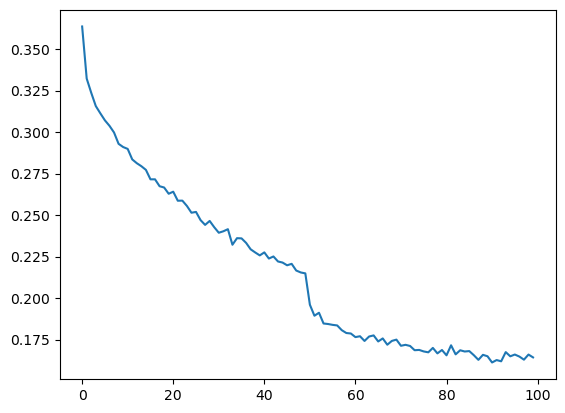

In [103]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

### Evaluation

In [104]:
@torch.no_grad()
def split_loss(split): 
    X, Y = {
        "train": (Xtr, Ytr),
        "val": (Xva, Yva),
        "test": (Xte, Yte)
    }[split]
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

for layer in model.layers:
    layer.training = False
    
split_loss("train")
split_loss("val")

train 1.4048711061477661
val 2.2751305103302


#### Performance log
- Original (3 characters + 200 hidden neurons + 12K params): train 1.887, val 2.097
- Optimized (8 characters + 200 hidden neurons + 22K params): train 1.604, val 2.184
- WaveNet (8 characters + 68 hidden neurons + 22K params): train: 1.684, val 2.093

### Next Word Generation

In [42]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join([itos[i] for i in out]))

bigrudi.
krajant.
kailsir.
rabib.
udanjai.
reena.
yogini.
shrajit.
dhanav.
narjan.
renthan.
dalni.
aasmit.
bhagilal.
pram.
husuvan.
rami.
sharunora.
shakha.
fariharan.
